In [5]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
from snAPI.Main import *
import pandas as pd
sys.path.append("../")
from HH import HH_T3
from Functions import *
import time

# Functions

In [6]:
def getcols(m1,nrows):
    arr=np.array([])
    for elem in np.cumsum(m1):
        rest=elem%(nrows)
        inte=elem//(nrows)
        if inte%2==1:
            a=nrows-rest
        else:
            a=rest 
        arr=np.append(arr,a)       
    return arr

f=lambda x : nrows-x%(nrows) if x//(nrows)%2==1 else x%(nrows) # this is the lambda version of getcols (much faster)

In [7]:
def positions(df,step):
    xs=np.unique(df['row'])*step
    ys=np.unique(df['col'])*step
    return xs,ys
    

# Select file

In [28]:
filename='../../../Acquisition2/Data/QD1e-1_0.7MO/Images/PTU_-5.0_5.0_20_-5.0_5.0_20.ptu'
os.listdir(filename)

NotADirectoryError: [WinError 267] El nombre del directorio no es válido: '../../../Acquisition2/Data/QD1e-1_0.7MO/Images/PTU_-5.0_5.0_20_-5.0_5.0_20.ptu'

# Create data structure 

In [29]:
sn=snAPI()
sn.getDevice()
sn.getFileDevice(filename)
sn.initDevice(MeasMode.T3)
sn.unfold.setT3Format(format=UnfoldFormat.DTimesSyncCntr)
sn.unfold.measure()
times, channels = sn.unfold.getBlock()
dtimes=sn.unfold.dTime_T3(times)
markers_Bool=np.array([sn.unfold.isMarker(datai) for datai in channels])
m1=markers_Bool*sn.unfold.markers(channels)[2]
m2=markers_Bool*sn.unfold.markers(channels)[3]
m3=markers_Bool*sn.unfold.markers(channels)[1]


In [30]:
np.sum(m1)

380

In [31]:
cum=np.cumsum(markers_Bool)
rm=np.array([n%2 for n in cum])
row=np.array(np.cumsum(m2),dtype=int)
df=pd.DataFrame(np.array([dtimes,times,channels,markers_Bool,m1,m2,m3,rm]).T,columns=['dTimes','absTimes','Channels','markers','m1','m2','m3','rm'])
df['row']=row
nrows=np.sum(df['m1'][df['row']==2])
col=np.array([f(x) for x in np.cumsum(m1)],dtype=int)
df['col']=col

In [32]:

df['cm3']=np.cumsum(df['m3'])
data= df[df['rm'] !=0]
data=data[data['Channels']==3]
data=data[data['cm3']!=0]#remove data before starting measurement (data start after the first m3 marker)
data=data.drop(columns=['m1', 'm2','m3','markers','rm'])

# X Y positions: ROW an COLs

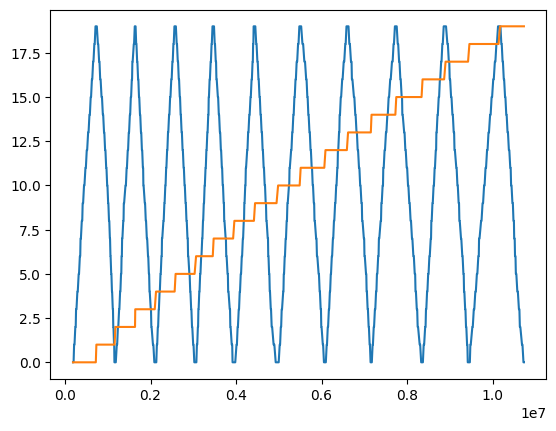

In [35]:
plt.plot(data['col'])
plt.plot(data['row'])

# Reconstruct image

In [36]:
xs=np.unique(df['row'])
ys=np.unique(df['col'])
M=np.zeros((np.size(xs),np.size(ys)))
for xi in xs:
    for yi in ys:
        M[xi,yi]=np.size(data['dTimes'][(data['row']==xi)&(data['col']==yi)])
M[0,0]=M[0,1]
#M=np.array([[np.size(data['dTimes'][(data['row']==xi)&(data['col']==yi)]) for xi in xs] for yi in ys])

In [37]:
x,y=positions(df,0.2)

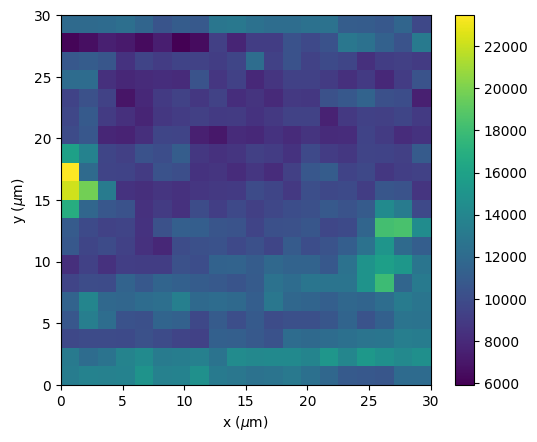

In [38]:
plt.imshow(M,extent=[0,30,0,30])
plt.xlabel('x ($\mu$m)')
plt.ylabel('y ($\mu$m)')
plt.colorbar()

# Analyze line

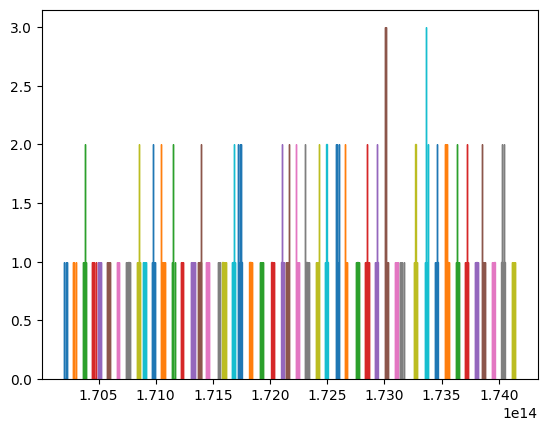

In [97]:
l=42
for i in range (int(nrows)):
    d=data[(data['row']==l)&(data['col']==i)]
    plt.hist(d['absTimes'],bins=100,histtype=u'step')
plt.yscale('linear')
    

# Analyze individual pixel

In [56]:
d=data[(data['row']==42)&(data['col']==20)]

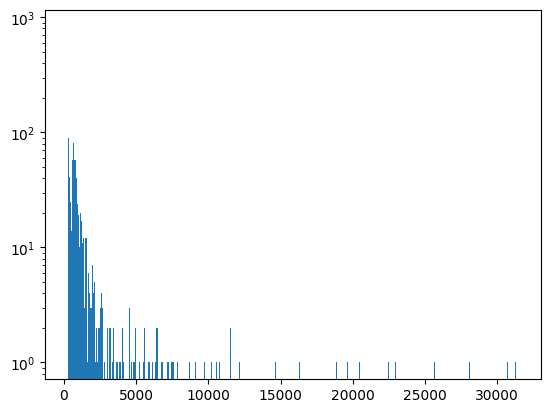

In [57]:
plt.hist(d['dTimes'],bins=500);
plt.yscale('log')

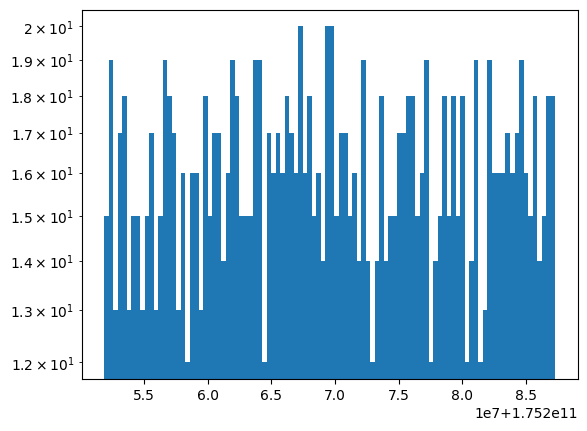

In [58]:
plt.hist(d['absTimes'],bins=100);
plt.yscale('log')